In [9]:
# Agentic IEEE Reference Pipeline (LangGraph) — Single Jupyter Cell (Production Grade, Updated)
# - Robust LLM adapter (OpenAI/Azure/Anthropic/Ollama), JSON-only w/ deterministic params
# - Async concurrent lookups + retries/backoff: Crossref/OpenAlex/Semantic Scholar/PubMed/arXiv
# - Better matching (top-N fetch + trust guard), author formatting, e-locator handling, DOI links
# - Verification agents + repair loop with improved circuit breakers
# - Mermaid graph rendering via inline JS (no extension) + Kroki SVG fallback (guarded)
# - Exports: IEEE string, CSL-JSON (w/ abbrev, URL), BibTeX (w/ url)
# - Structured logs (_jlog), polite User-Agent, optional API keys, pydantic validation for LLM JSON

import os, re, json, asyncio, logging, textwrap, hashlib, time, sys
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple
from typing_extensions import TypedDict

# ---------- Optional deps ----------
try:
    from dotenv import load_dotenv; load_dotenv()
except Exception:
    pass

try:
    import httpx
except Exception:
    httpx = None

try:
    from cachetools import TTLCache
    CACHE_AVAILABLE = True
except Exception:
    TTLCache = None
    CACHE_AVAILABLE = False

try:
    from rapidfuzz import fuzz
    RF_AVAILABLE = True
except Exception:
    fuzz = None
    RF_AVAILABLE = False

try:
    from pydantic import BaseModel, ValidationError
except Exception:
    class BaseModel:  # fallback no-op
        def __init__(self, **kw): pass
        def dict(self, **kw): return {}
    class ValidationError(Exception): ...
    BaseModel = BaseModel
    ValidationError = ValidationError

from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, Markdown, Image, SVG, HTML

# LangGraph
from langgraph.graph import StateGraph, START, END

# ============================ Configuration & Logging ============================

@dataclass
class PipelineConfig:
    timeout_s: float = float(os.getenv("IEEE_REF_TIMEOUT", "12"))
    concurrency: int = int(os.getenv("IEEE_REF_CONCURRENCY", "8"))
    cache_ttl_s: int = int(os.getenv("IEEE_REF_CACHE_TTL", "3600"))
    max_correction_rounds: int = int(os.getenv("IEEE_REF_MAX_CORR", "3"))
    max_hops: int = int(os.getenv("IEEE_REF_MAX_HOPS", "12"))
    stagnation_patience: int = int(os.getenv("IEEE_REF_STAGNATION", "2"))
    llm_provider: str = os.getenv("IEEE_REF_LLM", "auto")  # auto|openai|azure|anthropic|ollama|dummy
    openai_model: str = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    ollama_model: str = os.getenv("OLLAMA_MODEL", "llama3.2")
    ollama_base: str = os.getenv("OLLAMA_BASE_URL", os.getenv("OLLAMA_HOST", "http://localhost:11434"))
    agent_threads: int = int(os.getenv("IEEE_REF_AGENT_THREADS", "6"))
    recursion_limit: int = int(os.getenv("IEEE_REF_RECURSION_LIMIT", "60"))

LOG_LEVEL = os.getenv("IEEE_REF_LOG_LEVEL", "INFO").upper()
logging.basicConfig(level=getattr(logging, LOG_LEVEL, logging.INFO), format="%(message)s")
logger = logging.getLogger("ieee-ref-langgraph")
import json as _json
def _jlog(**kw):
    try:
        print(_json.dumps(kw, ensure_ascii=False))
    except Exception:
        print(str(kw))

CFG = PipelineConfig()
DEFAULT_UA = "ieee-ref-agent/1.0 (mailto:you@example.com)"

# ============================ Utility Functions ============================

def safe_json_load(s: Any) -> Optional[Dict[str, Any]]:
    if s is None:
        return None
    if isinstance(s, dict):
        return s
    try:
        sx = s.decode("utf-8", "ignore") if isinstance(s, (bytes, bytearray)) else str(s)
    except Exception:
        sx = str(s)
    sx = sx.strip()
    try:
        if sx.startswith("{"):
            return json.loads(sx)
    except Exception:
        pass
    # brace-balanced extraction
    i, n = 0, len(sx)
    while i < n and sx[i] != "{": i += 1
    if i >= n: return None
    stack = 0; in_str = False; esc = False; start = None
    for j in range(i, n):
        ch = sx[j]
        if in_str:
            if esc: esc = False
            elif ch == "\\": esc = True
            elif ch == '"': in_str = False
        else:
            if ch == '"': in_str = True
            elif ch == "{":
                if stack == 0: start = j
                stack += 1
            elif ch == "}":
                stack -= 1
                if stack == 0 and start is not None:
                    candidate = sx[start:j+1]
                    try: return json.loads(candidate)
                    except Exception: start = None
    return None

def normalize_text(x: Any) -> str:
    if x is None: return ""
    s = str(x).strip()
    s = re.sub(r"\s+", " ", s)
    return s

def norm_for_compare(x: Any) -> str:
    s = normalize_text(x).lower()
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def token_similarity(a: str, b: str) -> float:
    a = norm_for_compare(a); b = norm_for_compare(b)
    if not a or not b: return 0.0
    if RF_AVAILABLE and fuzz is not None:
        return fuzz.token_sort_ratio(a, b) / 100.0
    sa, sb = set(a.split()), set(b.split())
    inter = sa & sb
    union = sa | sb
    return len(inter) / max(1, len(union))

def authors_to_list(a: Any) -> List[str]:
    if not a: return []
    if isinstance(a, list):
        return [normalize_text(x) for x in a if normalize_text(x)]
    parts = re.split(r",\s*|\s+&\s+| and ", str(a))
    return [normalize_text(p) for p in parts if normalize_text(p)]

SUFFIXES = {"jr", "jr.", "sr", "sr.", "ii", "iii", "iv", "v"}

def _initials(given: str) -> List[str]:
    parts = re.split(r"\s+", given.strip())
    out=[]
    for p in parts:
        if not p: continue
        hy = p.split("-")
        if len(hy)>1:
            out.append("-".join([h[0].upper()+"." for h in hy if h]))
        elif re.match(r"^[A-Za-z]\.$", p):
            out.append(p.upper())
        elif p.lower().rstrip(".") in SUFFIXES:
            out.append(p.capitalize().rstrip(".")+".")
        else:
            out.append(p[0].upper()+".")
    return out

def format_author_ieee(name: str) -> str:
    n = normalize_text(name)
    if not n: return ""
    if "," in n:
        last, given = [p.strip() for p in n.split(",", 1)]
    else:
        toks = n.split()
        if len(toks) == 1: return toks[0]
        last = toks[-1]; given = " ".join(toks[:-1])
    init = " ".join(_initials(given))
    last_tokens = last.split()
    if last_tokens and last_tokens[-1].lower().rstrip(".") in SUFFIXES:
        suf = last_tokens[-1].capitalize().rstrip(".")+"."
        last = " ".join(last_tokens[:-1])
        return f"{init} {last}, {suf}".strip(", ")
    return f"{init} {last}".strip()

def format_authors_ieee_list(auths: List[str]) -> str:
    items = [format_author_ieee(a) for a in auths if a]
    if not items: return ""
    if len(items) <= 6:
        return ", ".join(items[:-1]) + (", and " if len(items) > 1 else "") + items[-1] if len(items) > 1 else items[0]
    return ", ".join(items[:6]) + ", et al."

def sentence_case(title: str) -> str:
    t = normalize_text(title)
    if not t: return ""
    if t.isupper(): t = t.lower()
    tokens = t.split(); out = []
    for i, tok in enumerate(tokens):
        if tok.isupper() and len(tok) > 1:
            out.append(tok)
        else:
            out.append(tok[:1].upper() + tok[1:].lower() if i == 0 else tok.lower())
    res = " ".join(out)
    res = re.sub(r"\bieee\b", "IEEE", res, flags=re.I)
    return res

def heuristic_abbrev(fullname: str) -> str:
    fullname = normalize_text(fullname)
    if not fullname: return ""
    tokens = [t for t in re.split(r"[\s,]+", fullname) if t.lower() not in {"on","of","and","the","in","for","to"}]
    out = []
    for t in tokens[:8]:
        if len(t) <= 4 and t.isupper(): out.append(t)
        elif len(t) <= 3: out.append(t.capitalize() + ".")
        else: out.append(t[:4].capitalize() + ".")
    return " ".join(out)

def ensure_doi_prefix(doi: str) -> str:
    # kept for compatibility; not used anymore
    d = normalize_text(doi)
    if not d: return ""
    return d if d.lower().startswith("doi:") else f"doi:{d}"

def format_doi_link(doi: str) -> str:
    d = normalize_text(doi).lower().replace("doi:","").strip()
    return f"https://doi.org/{d}" if d else ""

def normalize_pages(p: str) -> Tuple[str, bool]:
    p = normalize_text(p).replace("—","-").replace("–","-")
    if not p: return "", False
    # Treat single token or alphanumeric token without dash as eLocator/article number
    if ("-" not in p) and re.fullmatch(r"[A-Za-z]?\d+[A-Za-z]?", p):
        return p, True
    return p, False

MONTHS_NAME = {
    "1":"Jan","2":"Feb","3":"Mar","4":"Apr","5":"May","6":"Jun",
    "7":"Jul","8":"Aug","9":"Sep","10":"Oct","11":"Nov","12":"Dec",
}
def normalize_month_field(m: Any) -> str:
    s = normalize_text(m)
    if not s: return ""
    m_map = {"jan":"1","feb":"2","mar":"3","apr":"4","may":"5","jun":"6","jul":"7","aug":"8","sep":"9","sept":"9","oct":"10","nov":"11","dec":"12"}
    sl = s.strip(". ").lower()
    if sl in m_map: return m_map[sl]
    if re.fullmatch(r"0?[1-9]|1[0-2]", sl): return str(int(sl))
    return s

def fingerprint_state(ex: Dict[str, Any], best: Dict[str, Any], sugg: Dict[str, Any]) -> str:
    payload = json.dumps({"ex": ex, "best": best, "sugg": sugg}, sort_keys=True, ensure_ascii=False)
    return hashlib.sha256(payload.encode("utf-8", "ignore")).hexdigest()

def safe_str(v: Any) -> str:
    try:
        if v is None:
            return ""
        return str(v).strip()
    except Exception:
        return ""

# ============================ Validation Model ============================

class ExtractedModel(BaseModel):
    title: Optional[str] = None
    authors: Optional[List[str]] = None
    journal_name: Optional[str] = None
    journal_abbrev: Optional[str] = None
    conference_name: Optional[str] = None
    volume: Optional[str] = None
    issue: Optional[str] = None
    pages: Optional[str] = None
    year: Optional[str] = None
    month: Optional[str] = None
    doi: Optional[str] = None
    publisher: Optional[str] = None
    location: Optional[str] = None
    edition: Optional[str] = None
    isbn: Optional[str] = None
    url: Optional[str] = None
    arxiv_id: Optional[str] = None

# ============================ LLM Adapter ============================

class LLMAdapter:
    """LLM JSON-mode adapter supporting OpenAI, Azure OpenAI, Anthropic, Ollama; falls back to dummy."""
    def __init__(self, cfg: PipelineConfig):
        self.cfg = cfg
        self.provider = self._auto_provider(cfg.llm_provider)
        self._client = None
        self._init_client()
        _jlog(event="llm_provider_selected", provider=self.provider)

    def _auto_provider(self, p: str) -> str:
        if p != "auto":
            return p
        if os.getenv("OPENAI_API_KEY"): return "openai"
        if os.getenv("AZURE_OPENAI_API_KEY"): return "azure"
        if os.getenv("ANTHROPIC_API_KEY"): return "anthropic"
        if os.getenv("OLLAMA_BASE_URL") or os.getenv("OLLAMA_HOST"): return "ollama"
        return "dummy"

    def _init_client(self):
        prov = self.provider
        try:
            if prov == "openai":
                from openai import OpenAI
                base = os.getenv("OPENAI_API_BASE")
                self._client = OpenAI(base_url=base) if base else OpenAI()
            elif prov == "azure":
                from openai import AzureOpenAI
                ep = os.getenv("AZURE_OPENAI_ENDPOINT")
                ver = os.getenv("OPENAI_API_VERSION", "2024-06-01")
                if not ep:
                    raise RuntimeError("AZURE_OPENAI_ENDPOINT is not set")
                self._client = AzureOpenAI(azure_endpoint=ep, api_version=ver)
            elif prov == "anthropic":
                import anthropic
                self._client = anthropic.AsyncAnthropic()
            elif prov == "ollama" and httpx is not None:
                base = os.getenv("OLLAMA_BASE_URL") or os.getenv("OLLAMA_HOST") or self.cfg.ollama_base
                self._client = httpx.AsyncClient(base_url=base, timeout=self.cfg.timeout_s)
            else:
                self._client = None
        except Exception as e:
            logger.warning("LLM init failed: %s", e)
            self._client = None
            self.provider = "dummy"

    async def _openai_json(self, prompt: str) -> str:
        model = self.cfg.openai_model
        resp = self._client.chat.completions.create(
            model=model,
            messages=[{"role":"system","content":"Return STRICT JSON only. No prose."},
                      {"role":"user","content":prompt}],
            temperature=0.1,
            top_p=0.1,
            response_format={"type":"json_object"},
        )
        return resp.choices[0].message.content

    async def _azure_json(self, prompt: str) -> str:
        deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT") or self.cfg.openai_model
        resp = self._client.chat.completions.create(
            model=deployment,
            messages=[{"role":"system","content":"Return STRICT JSON only. No prose."},
                      {"role":"user","content":prompt}],
            temperature=0.1,
            top_p=0.1,
            response_format={"type":"json_object"},
        )
        return resp.choices[0].message.content

    async def _anthropic_json(self, prompt: str) -> str:
        msg = await self._client.messages.create(
            model=os.getenv("ANTHROPIC_MODEL","claude-3-5-sonnet-20240620"),
            system="Return STRICT JSON only. No prose.",
            max_tokens=1024, temperature=0.1,
            messages=[{"role":"user","content":prompt}],
        )
        texts = []
        for c in msg.content:
            if getattr(c, "type", None) == "text":
                texts.append(c.text)
        return "".join(texts)

    async def _ollama_json(self, prompt: str) -> str:
        data = {"model": self.cfg.ollama_model, "prompt": "Return STRICT JSON only.\n\n" + prompt, "stream": False}
        r = await self._client.post("/api/generate", json=data)
        r.raise_for_status()
        return r.json().get("response","")

    async def json(self, prompt: str) -> Dict[str, Any]:
        try:
            if self.provider == "openai":
                raw = await self._openai_json(prompt)
            elif self.provider == "azure":
                raw = await self._azure_json(prompt)
            elif self.provider == "anthropic":
                raw = await self._anthropic_json(prompt)
            elif self.provider == "ollama":
                raw = await self._ollama_json(prompt)
            else:
                return {}
            return safe_json_load(raw) or {}
        except Exception as e:
            logger.warning("LLM json() failed: %s", e)
            return {}

# ============================ Async Source Clients ============================

ARXIV_RE = re.compile(r'(arxiv:)?\s*(\d{4}\.\d{4,5})(v\d+)?', re.I)
DOI_RE = re.compile(r'(10\.\d{4,9}/[^\s,;]+)', re.I)

class SourceClient:
    NAME: str = "base"
    def __init__(self, cfg: PipelineConfig, client=None, limiter=None, cache=None):
        self.cfg = cfg
        self.client = client or (httpx.AsyncClient(timeout=httpx.Timeout(connect=cfg.timeout_s, read=cfg.timeout_s, write=cfg.timeout_s, pool=cfg.timeout_s)) if httpx is not None else None)
        self.limiter = limiter or asyncio.Semaphore(cfg.concurrency)
        self.cache = cache

    def _cache_get(self, key: str):
        if not self.cache: return None
        return self.cache.get((self.NAME, key))

    def _cache_set(self, key: str, val: Dict[str, Any]):
        if not self.cache: return
        self.cache[(self.NAME, key)] = val

    async def _get_json(self, url: str, params: Optional[Dict[str, Any]] = None, headers: Optional[Dict[str, str]] = None) -> Dict[str, Any]:
        if self.client is None:
            raise RuntimeError("HTTP client unavailable.")
        hdrs = {"User-Agent": DEFAULT_UA}
        if headers: hdrs.update(headers)

        attempt = 0
        while True:
            attempt += 1
            try:
                async with self.limiter:
                    r = await self.client.get(url, params=params, headers=hdrs)
                _jlog(event="http_request", url=str(r.request.url), code=r.status_code)
                if r.status_code in (429, 500, 502, 503, 504) and attempt <= 4:
                    await asyncio.sleep(min(2**attempt, 8) + (0.1 * attempt))
                    continue
                r.raise_for_status()
                ct = r.headers.get("content-type","")
                if "json" in ct:
                    return r.json()
                return {"_raw": r.text}
            except Exception as e:
                if attempt <= 2:
                    await asyncio.sleep(0.3 * attempt)
                    continue
                raise

    async def by_doi(self, doi: str) -> Optional[Dict[str, Any]]: raise NotImplementedError
    async def by_title(self, title: str) -> Optional[Any]: raise NotImplementedError

class CrossrefClient(SourceClient):
    NAME = "crossref"; BASE_URL = "https://api.crossref.org/works"
    async def by_doi(self, doi: str) -> Optional[Dict[str, Any]]:
        key = f"doi:{doi.lower().strip()}"
        if (c := self._cache_get(key)): return c
        try:
            data = await self._get_json(f"{self.BASE_URL}/{doi}")
            msg = data.get("message")
            if msg: self._cache_set(key, msg)
            return msg
        except Exception: return None
    async def by_title(self, title: str) -> Optional[List[Dict[str, Any]]]:
        key = f"title:{norm_for_compare(title)}"
        c = self._cache_get(key)
        # We'll still fetch up to 5; but keep first item in cache for speed
        params = {
            "query.title": title,
            "rows": 5,
            "select":"title,author,container-title,short-container-title,issued,DOI,page,volume,issue,published-print,published-online,type"
        }
        try:
            data = await self._get_json(self.BASE_URL, params=params)
            items = data.get("message", {}).get("items", [])[:5]
            if items and not c:
                self._cache_set(key, items[0])
            return items
        except Exception: return None

class OpenAlexClient(SourceClient):
    NAME = "openalex"; BASE_URL = "https://api.openalex.org/works"
    async def by_doi(self, doi: str) -> Optional[Dict[str, Any]]:
        key = f"doi:{doi.lower().strip()}"
        if (c := self._cache_get(key)): return c
        try:
            headers = {"User-Agent": DEFAULT_UA}
            data = await self._get_json(self.BASE_URL, params={"filter": f"doi:{doi}"}, headers=headers)
            items = data.get("results", [])
            it = items[0] if items else None
            if it: self._cache_set(key, it)
            return it
        except Exception: return None
    async def by_title(self, title: str) -> Optional[List[Dict[str, Any]]]:
        key = f"title:{norm_for_compare(title)}"
        try:
            headers = {"User-Agent": DEFAULT_UA}
            data = await self._get_json(self.BASE_URL, params={"filter": f"title.search:{title}", "per-page":5}, headers=headers)
            items = data.get("results", [])[:5]
            return items
        except Exception: return None

class SemanticScholarClient(SourceClient):
    NAME = "semanticscholar"; BASE_URL = "https://api.semanticscholar.org/graph/v1/paper"
    S2_KEY = os.getenv("SEMANTIC_SCHOLAR_API_KEY")
    def _headers(self):
        h = {"User-Agent": DEFAULT_UA}
        if self.S2_KEY: h["x-api-key"] = self.S2_KEY
        return h
    async def by_doi(self, doi: str) -> Optional[Dict[str, Any]]:
        key = f"doi:{doi.lower().strip()}"
        if (c := self._cache_get(key)): return c
        try:
            data = await self._get_json(f"{self.BASE_URL}/DOI:{doi}", params={"fields":"title,venue,year,authors,externalIds,publicationVenue,publicationTypes"}, headers=self._headers())
            if data and not data.get("error"): self._cache_set(key, data)
            return data if data and not data.get("error") else None
        except Exception: return None
    async def by_title(self, title: str) -> Optional[List[Dict[str, Any]]]:
        try:
            data = await self._get_json(
                f"{self.BASE_URL}/search",
                params={"query": title, "limit":5, "fields":"title,venue,year,authors,externalIds,publicationVenue,publicationTypes"},
                headers=self._headers()
            )
            items = data.get("data") or []
            return items[:5]
        except Exception: return None

class PubMedClient(SourceClient):
    NAME = "pubmed"
    ESEARCH = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    ESUMMARY = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
    async def by_doi(self, doi: str) -> Optional[Dict[str, Any]]:
        return None
    async def by_title(self, title: str) -> Optional[Dict[str, Any]]:
        key = f"title:{norm_for_compare(title)}"
        if (c := self._cache_get(key)): return c
        try:
            d = await self._get_json(self.ESEARCH, params={"db":"pubmed","term":title,"retmode":"json","retmax":"1","tool":"ieee-ref-agent","email":"you@example.com"})
            ids = d.get("esearchresult", {}).get("idlist", [])
            if not ids: return None
            pmid = ids[0]
            d2 = await self._get_json(self.ESUMMARY, params={"db":"pubmed","id":pmid,"retmode":"json","tool":"ieee-ref-agent","email":"you@example.com"})
            res = d2.get("result", {}).get(pmid)
            if res: self._cache_set(key, res)
            return res
        except Exception: return None

class ArxivClient(SourceClient):
    NAME = "arxiv"; BASE_URL = "https://export.arXiv.org/api/query"
    async def by_doi(self, doi: str) -> Optional[Dict[str, Any]]:
        return None
    async def by_title(self, title: str) -> Optional[Dict[str, Any]]:
        # keep title search for fallback
        try:
            if self.client is None:
                return None
            async with self.limiter:
                r = await self.client.get(self.BASE_URL, params={"search_query": f"ti:\"{title}\"", "start":0, "max_results":1}, headers={"Accept":"application/atom+xml","User-Agent":DEFAULT_UA})
                _jlog(event="http_request", url=str(r.request.url), code=r.status_code)
                r.raise_for_status()
                xml = r.text
                tmatch = re.search(r"<title>(.*?)</title>", xml, flags=re.DOTALL)
                if not tmatch: return None
                title0 = normalize_text(re.sub(r"\s+", " ", tmatch.group(1)))
                auths = [normalize_text(a) for a in re.findall(r"<name>(.*?)</name>", xml)]
                ymatch = re.search(r"<published>(\d{4})-", xml)
                year0 = ymatch.group(1) if ymatch else ""
                return {"title": title0, "authors": auths, "journal_name":"arXiv", "year": year0, "doi":""}
        except Exception:
            return None
    async def by_id(self, arx: str) -> Optional[Dict[str, Any]]:
        try:
            if self.client is None:
                return None
            async with self.limiter:
                r = await self.client.get(self.BASE_URL, params={"id_list": arx}, headers={"Accept":"application/atom+xml","User-Agent":DEFAULT_UA})
                _jlog(event="http_request", url=str(r.request.url), code=r.status_code)
                r.raise_for_status()
                xml = r.text
                tmatch = re.search(r"<title>(.*?)</title>", xml, flags=re.DOTALL)
                if not tmatch: return None
                title0 = normalize_text(re.sub(r"\s+", " ", tmatch.group(1)))
                auths = [normalize_text(a) for a in re.findall(r"<name>(.*?)</name>", xml)]
                ymatch = re.search(r"<published>(\d{4})-", xml)
                year0 = ymatch.group(1) if ymatch else ""
                return {"title": title0, "authors": auths, "journal_name":"arXiv", "year": year0, "doi":""}
        except Exception:
            return None

# ============================ Candidate normalization & scoring ============================

def normalize_candidate(source: str, rec: Dict[str, Any]) -> Dict[str, Any]:
    out: Dict[str, Any] = {"source": source, "raw": rec}
    if source == "crossref":
        out["title"] = normalize_text((rec.get("title") or [""])[0]) if rec.get("title") else ""
        out["authors"] = [normalize_text(f"{a.get('given','')} {a.get('family','')}".strip()) for a in rec.get("author", [])] if rec.get("author") else []
        out["journal_name"] = normalize_text((rec.get("container-title") or [""])[0]) if rec.get("container-title") else ""
        out["journal_abbrev"] = normalize_text((rec.get("short-container-title") or [""])[0]) if rec.get("short-container-title") else ""
        out["volume"] = normalize_text(rec.get("volume") or "")
        out["issue"]  = normalize_text(rec.get("issue") or "")
        out["pages"]  = normalize_text(rec.get("page") or "")
        out["doi"]    = normalize_text(rec.get("DOI") or "")
        out["cr_type"]= normalize_text(rec.get("type") or "")
        y, m = "", ""
        for src in ("issued","published-print","published-online"):
            dp = (rec.get(src) or {}).get("date-parts")
            if dp:
                y = str(dp[0][0])
                if len(dp[0])>1: m = str(dp[0][1])
                break
        out["year"], out["month"] = y, normalize_month_field(m)
    elif source == "openalex":
        out["title"] = normalize_text(rec.get("display_name") or rec.get("title") or "")
        out["authors"] = [normalize_text(a.get("author", {}).get("display_name") or "") for a in rec.get("authorships", [])] if rec.get("authorships") else []
        hv = rec.get("host_venue", {}) if isinstance(rec.get("host_venue"), dict) else {}
        out["journal_name"] = normalize_text(hv.get("display_name") or "")
        out["journal_abbrev"] = normalize_text(hv.get("abbrev") or "")
        out["doi"] = normalize_text(rec.get("doi") or "")
        out["volume"] = normalize_text(rec.get("biblio", {}).get("volume") or "")
        out["issue"]  = normalize_text(rec.get("biblio", {}).get("issue") or "")
        fp = rec.get("biblio", {}).get("first_page") or ""
        lp = rec.get("biblio", {}).get("last_page") or ""
        out["pages"] = f"{fp}-{lp}" if fp and lp else normalize_text(fp or "")
        out["year"]   = str(rec.get("publication_year") or (rec.get("from_publication_date") or "")[:4] or "")
        out["month"]  = ""
        out["oa_is_proceedings"] = "proceedings" in norm_for_compare(hv.get("display_name") or "")
    elif source == "semanticscholar":
        out["title"] = normalize_text(rec.get("title") or "")
        out["authors"] = [normalize_text(a.get("name") or "") for a in rec.get("authors", [])] if rec.get("authors") else []
        out["journal_name"] = normalize_text(rec.get("venue") or (rec.get("publicationVenue") or {}).get("name") or "")
        out["journal_abbrev"] = ""
        eid = rec.get("externalIds") or {}
        out["doi"] = normalize_text(eid.get("DOI") or rec.get("doi") or "")
        out["year"]   = normalize_text(rec.get("year") or "")
        out["month"]  = ""
        out["s2_types"] = [normalize_text(t) for t in (rec.get("publicationTypes") or [])]
    elif source == "pubmed":
        out["title"] = normalize_text(rec.get("title") or rec.get("sorttitle") or "")
        out["authors"] = [normalize_text(a.get("name")) for a in rec.get("authors", []) if a.get("name")] if rec.get("authors") else []
        out["journal_name"] = normalize_text((rec.get("fulljournalname") or rec.get("source") or ""))
        out["journal_abbrev"] = normalize_text(rec.get("source") or "")
        out["doi"] = normalize_text((rec.get("elocationid") or "").replace("doi:","").strip())
        out["volume"] = normalize_text(rec.get("volume") or "")
        out["issue"]  = normalize_text(rec.get("issue") or "")
        out["pages"]  = normalize_text(rec.get("pages") or "")
        out["year"]   = normalize_text((rec.get("pubdate") or "").split(" ")[0])
        out["month"]  = ""
    elif source == "arxiv":
        out["title"] = normalize_text(rec.get("title") or "")
        out["authors"] = [normalize_text(a) for a in rec.get("authors", [])]
        out["journal_name"] = "arXiv"
        out["journal_abbrev"] = "arXiv"
        out["doi"] = normalize_text(rec.get("doi") or "")
        out["year"] = normalize_text(rec.get("year") or "")
        out["month"] = ""
        out["volume"] = ""
        out["issue"] = ""
        out["pages"] = ""
    else:
        out.update({k:"" for k in ("title","authors","journal_name","journal_abbrev","doi","volume","issue","pages","year","month")})
    return out

def score_candidate(extracted: Dict[str, Any], cand: Dict[str, Any]) -> float:
    score = 0.0
    ex_doi = normalize_text(extracted.get("doi") or "").lower().replace("doi:","")
    ca_doi = normalize_text(cand.get("doi") or "").lower().replace("doi:","")
    if ex_doi and ca_doi and ex_doi == ca_doi: score += 1.0
    score += 0.6 * token_similarity(extracted.get("title") or "", cand.get("title") or "")
    ex_auth = [a.split()[-1].lower() for a in authors_to_list(extracted.get("authors")) if a.split()]
    ca_auth = [a.split()[-1].lower() for a in authors_to_list(cand.get("authors")) if a.split()]
    if ex_auth and ca_auth:
        inter = len(set(ex_auth) & set(ca_auth))
        score += 0.2 * (inter / max(1, len(set(ex_auth) | set(ca_auth))))
    ey = str(extracted.get("year") or "").strip()
    cy = str(cand.get("year") or "").strip()
    if ey and cy and ey == cy: score += 0.1
    src_weight = {"crossref": 0.12, "openalex": 0.08, "semanticscholar": 0.06, "pubmed": 0.05, "arxiv": 0.03}
    score += src_weight.get(cand.get("source",""), 0.0)
    return score

# ============================ Type reconciliation ============================

TYPE_CANON = {
    "journal-article": "journal article",
    "paper-conference": "conference paper",
    "proceedings-article": "conference paper",
    "book-chapter": "book chapter",
    "book": "book",
    "dataset": "dataset",
    "standard": "standard",
    "report": "technical report",
    "thesis": "thesis",
}

def reconcile_type(initial_type: str, candidates: List[Dict[str, Any]], llm_vote: Optional[str]) -> str:
    votes = []
    if initial_type: votes.append(initial_type)
    if llm_vote: votes.append(llm_vote.lower())
    for c in candidates or []:
        if c["source"] == "crossref":
            t = c.get("cr_type","")
            if t: votes.append(TYPE_CANON.get(t, t))
        elif c["source"] == "openalex":
            if c.get("oa_is_proceedings"): votes.append("conference paper")
        elif c["source"] == "semanticscholar":
            types = c.get("s2_types") or []
            if any("conference" in t for t in types): votes.append("conference paper")
            if any("journal" in t for t in types): votes.append("journal article")
            if any("book" in t for t in types): votes.append("book")
        elif c["source"] == "arxiv":
            votes.append("preprint")
    from collections import Counter
    cnt = Counter([v.lower() for v in votes if v])
    if not cnt: return initial_type or "other"
    return cnt.most_common(1)[0][0]

# ============================ Verification Agents (threaded) ============================

def _prefer_abbrev(a: str, b: str) -> str:
    cand = [x for x in [a, b] if x]
    if not cand: return ""
    def score(x):
        s = x.strip()
        return (sum(1 for c in s if c.isupper()), -len(s))
    return sorted(cand, key=score, reverse=True)[0]

def agent_journal(extracted: Dict[str, Any], best: Dict[str, Any]) -> Dict[str, Any]:
    ex_j = normalize_text(extracted.get("journal_name") or "")
    ex_ab = normalize_text(extracted.get("journal_abbrev") or "")
    be_j = normalize_text(best.get("journal_name") or "")
    be_ab = normalize_text(best.get("journal_abbrev") or "")
    sim_full = token_similarity(ex_j, be_j) if ex_j and be_j else 0.0
    sim_ab   = token_similarity(ex_ab, be_ab) if ex_ab and be_ab else 0.0
    ok = (sim_full >= 0.6) or (sim_ab >= 0.6) or (bool(ex_j) and not be_j)
    corr = {}
    if be_j and be_j != ex_j: corr["journal_name"] = be_j
    if (be_ab and be_ab != ex_ab) or (not ex_ab and (be_ab or be_j)):
        chosen = _prefer_abbrev(be_ab, heuristic_abbrev(be_j or ex_j))
        corr["journal_abbrev"] = chosen
    return {"ok": ok, "correction": corr or None}

def agent_authors(extracted: Dict[str, Any], best: Dict[str, Any]) -> Dict[str, Any]:
    ex = authors_to_list(extracted.get("authors"))
    be = authors_to_list(best.get("authors"))
    if be:
        matches = 0
        for ea in ex:
            last = ea.split()[-1].lower() if ea.split() else ""
            if any((ba.split()[-1].lower() if ba.split() else "") == last for ba in be):
                matches += 1
        required = max(1, int(0.5 * len(ex))) if ex else 1
        if matches >= required:
            if any(re.match(r"^[A-Z]\.", p.split()[0]) if p.split() else False for p in ex[:3]):
                return {"ok": True, "correction": {"authors": be}}
            return {"ok": True}
        return {"ok": False, "correction": {"authors": be}}
    return {"ok": bool(ex)}

def agent_title(extracted: Dict[str, Any], best: Dict[str, Any]) -> Dict[str, Any]:
    ex_t = normalize_text(extracted.get("title") or "")
    be_t = normalize_text(best.get("title") or "")
    desired = sentence_case(ex_t) if ex_t else ""
    if be_t:
        sim = token_similarity(ex_t, be_t)
        if sim >= 0.7:
            if ex_t != desired:
                return {"ok": True, "correction": {"title": desired}}
            return {"ok": True}
        return {"ok": False, "correction": {"title": be_t}}
    else:
        if ex_t and ex_t != desired:
            return {"ok": False, "correction": {"title": desired}}
        return {"ok": bool(ex_t)}

def agent_year_month(extracted: Dict[str, Any], best: Dict[str, Any]) -> Dict[str, Any]:
    ex_y = str(extracted.get("year") or "")
    ex_m = normalize_month_field(extracted.get("month") or "")
    be_y = str(best.get("year") or "")
    be_m = normalize_month_field(best.get("month") or "")
    ok = True; corr = {}
    if be_y and be_y != ex_y: corr["year"] = be_y; ok = False
    if be_m and be_m != ex_m: corr["month"] = be_m; ok = False
    return {"ok": ok, "correction": corr or None}

def agent_vipd(extracted: Dict[str, Any], best: Dict[str, Any]) -> Dict[str, Any]:
    exv, exi, exp, exd = [normalize_text(extracted.get(k) or "") for k in ("volume","issue","pages","doi")]
    bev, bei, bep, bed = [normalize_text(best.get(k) or "") for k in ("volume","issue","pages","doi")]
    ok = True; corr = {}
    if bev and bev != exv: corr["volume"] = bev; ok = False
    if bei and bei != exi: corr["issue"]  = bei; ok = False
    if bep and bep != exp: corr["pages"]  = bep; ok = False
    if bed and bed.lower().replace("doi:","") != exd.lower().replace("doi:",""):
        corr["doi"] = bed; ok = False
    return {"ok": ok, "correction": corr or None}

def agent_presence(extracted: Dict[str, Any], best: Dict[str, Any]) -> Dict[str, Any]:
    return {"ok": bool(extracted.get("title")) and bool(extracted.get("authors"))}

# ============================ LangGraph State & Nodes ============================

class PipelineState(TypedDict, total=False):
    reference: str
    type: str
    extracted: Dict[str, Any]
    candidates: List[Dict[str, Any]]
    best: Dict[str, Any]
    verification: Dict[str, bool]
    suggestions: Dict[str, Any]
    corrections: List[Tuple[str, Any, Any]]
    formatted: str
    report: str
    attempts: int
    hops: int
    _made_changes_last_cycle: bool
    _cfg: PipelineConfig
    _llm: Any
    _http: Any
    _cache: Any
    _limiter: Any
    _sources: Any
    _llm_type_vote: Optional[str]
    csl_json: Dict[str, Any]
    bibtex: str
    _ver_score: int
    _stagnation: int
    _fp: str
    _fp_history: set
    _loop_detected: bool

async def _init_runtime(state: PipelineState) -> PipelineState:
    cfg = state.get("_cfg") or CFG
    llm = LLMAdapter(cfg)
    http = httpx.AsyncClient(timeout=httpx.Timeout(connect=cfg.timeout_s, read=cfg.timeout_s, write=cfg.timeout_s, pool=cfg.timeout_s)) if httpx is not None else None
    cache = TTLCache(maxsize=1000, ttl=cfg.cache_ttl_s) if CACHE_AVAILABLE and TTLCache is not None else None
    limiter = asyncio.Semaphore(cfg.concurrency)
    sources = [
        CrossrefClient(cfg, client=http, limiter=limiter, cache=cache),
        OpenAlexClient(cfg, client=http, limiter=limiter, cache=cache),
        SemanticScholarClient(cfg, client=http, limiter=limiter, cache=cache),
        PubMedClient(cfg, client=http, limiter=limiter, cache=cache),
        ArxivClient(cfg, client=http, limiter=limiter, cache=cache),
    ]
    state.update({
        "_cfg": cfg, "_llm": llm, "_http": http, "_cache": cache,
        "_limiter": limiter, "_sources": sources,
    })
    state.setdefault("hops", 0)
    state.setdefault("attempts", 0)
    state.setdefault("_ver_score", -1)
    state.setdefault("_stagnation", 0)
    state.setdefault("_fp", "")
    state.setdefault("_fp_history", set())
    state.setdefault("_loop_detected", False)
    state.setdefault("_made_changes_last_cycle", False)
    return state

# --- Detect type using heuristics + LLM vote (once) ---
async def node_detect_type_async(state: PipelineState) -> PipelineState:
    ref = state["reference"]
    rtype = "other"
    if re.search(r"\bvol\.|no\.|pp\.", ref, flags=re.I):
        rtype = "journal article"
    if re.search(r"\bin\b.+(proc|conference|symposium|workshop)", ref, flags=re.I):
        rtype = "conference paper"
    if re.search(r"\bISBN\b", ref, flags=re.I):
        rtype = "book"
    llm: LLMAdapter = state["_llm"]
    vote = await llm.json(
        "Classify this reference into one of: journal article, conference paper, book, book chapter, thesis, technical report, dataset, standard, software, other. "
        "Return JSON {\"type\": \"...\"}. Ref:\n" + ref
    )
    state["_llm_type_vote"] = (vote or {}).get("type")
    state["type"] = reconcile_type(rtype, [], state["_llm_type_vote"])
    return state

# --- Parse/extract using LLM-first with regex/arXiv/DOI fallback ---
async def node_parse_extract_async(state: PipelineState) -> PipelineState:
    ref, rtype = state["reference"], state["type"]
    llm: LLMAdapter = state["_llm"]
    prompt = (
        "Parse the IEEE-style reference. Return STRICT JSON. Keys among:\n"
        "title, authors (list or string), journal_name, journal_abbrev, conference_name,\n"
        "volume, issue, pages, year, month, doi, publisher, location, edition, isbn, url.\n"
        "Omit unknown keys. JSON ONLY.\n\n"
        f"Type hint: {rtype}\nReference: {ref}"
    )
    parsed = await llm.json(prompt)
    if not parsed:
        parsed = {}
        m = re.search(r"“([^”]{3,})”|\"([^\"]{3,})\"", ref)
        if m:
            parsed["title"] = normalize_text(m.group(1) or m.group(2))
            prefix = ref[:m.start()]
            parsed["authors"] = authors_to_list(prefix)
        dm = DOI_RE.search(ref)
        if dm: parsed["doi"] = dm.group(1)
        am = ARXIV_RE.search(ref)
        if am: parsed["arxiv_id"] = am.group(2)
        pm = re.search(r"pp\.?\s*([\d\u2013\u2014\-]+)", ref, flags=re.I)
        if pm: parsed["pages"] = pm.group(1).replace("\u2013","-").replace("\u2014","-")
        vm = re.search(r"vol\.?\s*([0-9A-Za-z]+)", ref, flags=re.I)
        if vm: parsed["volume"] = vm.group(1)
        im = re.search(r"no\.?\s*([0-9A-Za-z]+)", ref, flags=re.I)
        if im: parsed["issue"] = im.group(1)
        y = re.search(r"\b(19|20)\d{2}\b", ref)
        if y: parsed["year"] = y.group(0)
        if m:
            after = ref[m.end():]
            jm = re.search(r",\s*([^,]+?),", after)
            if jm: parsed["journal_name"] = normalize_text(jm.group(1))
    if isinstance(parsed.get("authors"), str):
        parsed["authors"] = authors_to_list(parsed["authors"])
    if parsed.get("month"):
        parsed["month"] = normalize_month_field(parsed["month"])
    try:
        parsed = ExtractedModel(**parsed).dict(exclude_none=True)
    except ValidationError as ve:
        _jlog(event="llm_parse_validation_error", errors=str(ve))
    state["extracted"] = parsed
    return state

# --- Multi-source lookup (concurrent, top-N, arXiv by id) ---
async def node_multisource_lookup_async(state: PipelineState) -> PipelineState:
    ex, sources = state["extracted"], state["_sources"]
    doi = normalize_text(ex.get("doi") or "").lower().replace("doi:","")
    title = normalize_text(ex.get("title") or "")
    arxiv_id = normalize_text(ex.get("arxiv_id") or "")

    tasks = []
    for s in sources:
        if arxiv_id and isinstance(s, ArxivClient):
            tasks.append(s.by_id(arxiv_id))
        if doi:
            tasks.append(s.by_doi(doi))
        if title:
            tasks.append(s.by_title(title))

    results = await asyncio.gather(*tasks, return_exceptions=True)
    out_norm: List[Dict[str, Any]] = []

    def _add(source_name, rec):
        if isinstance(rec, list):
            for r in rec:
                if r: out_norm.append(normalize_candidate(source_name, r))
        elif isinstance(rec, dict) and rec:
            out_norm.append(normalize_candidate(source_name, rec))

    idx = 0
    for s in sources:
        if arxiv_id and isinstance(s, ArxivClient):
            _add(s.NAME, results[idx]); idx+=1
        if doi:
            _add(s.NAME, results[idx]); idx+=1
        if title:
            _add(s.NAME, results[idx]); idx+=1

    dedup: Dict[Tuple[str, str], Dict[str, Any]] = {}
    for c in out_norm:
        key = (c["source"], c.get("doi") or c.get("title") or "")
        dedup[key] = c
    state["candidates"] = list(dedup.values())
    return state

def is_trustworthy_match(ex, cand) -> bool:
    ex_doi = normalize_text(ex.get("doi")).lower().replace("doi:","")
    ca_doi = normalize_text(cand.get("doi")).lower().replace("doi:","")
    if ex_doi and ca_doi and ex_doi == ca_doi:
        return True
    t_sim = token_similarity(ex.get("title",""), cand.get("title",""))
    ex_last = {a.split()[-1].lower() for a in authors_to_list(ex.get("authors")) if a.split()}
    ca_last = {a.split()[-1].lower() for a in authors_to_list(cand.get("authors")) if a.split()}
    return (t_sim >= 0.8) and bool(ex_last & ca_last)

def node_select_best(state: PipelineState) -> PipelineState:
    ex = state["extracted"]; candidates = state.get("candidates") or []
    if not candidates:
        state["best"] = {}
        return state
    best, best_score = None, -1.0
    for c in candidates:
        sc = score_candidate(ex, c)
        if sc > best_score:
            best, best_score = c, sc
    if best and not is_trustworthy_match(ex, best):
        _jlog(event="reject_candidate", reason="not_trustworthy", score=best_score, title=best.get("title"))
        best = {}
    state["best"] = best or {}
    return state

def node_reconcile_type(state: PipelineState) -> PipelineState:
    state["type"] = reconcile_type(state.get("type","other"), state.get("candidates") or [], state.get("_llm_type_vote"))
    return state

def node_verify_agents(state: PipelineState) -> PipelineState:
    ex = state["extracted"]
    be = state.get("best") or {}

    agents = [agent_journal, agent_authors, agent_title, agent_year_month, agent_vipd, agent_presence]
    results = {}
    with ThreadPoolExecutor(max_workers=CFG.agent_threads) as pool:
        fut_map = {pool.submit(a, ex, be): a.__name__ for a in agents}
        for fut in as_completed(fut_map):
            name = fut_map[fut]
            try:
                results[name] = fut.result()
            except Exception as e:
                logger.exception("Agent %s failed: %s", name, e)
                results[name] = {"ok": False}

    suggestions = {}
    for out in results.values():
        if out.get("correction"):
            suggestions.update(out["correction"])

    vipd_ok = results.get("agent_vipd", {}).get("ok", False)
    ym_ok = results.get("agent_year_month", {}).get("ok", False)

    verification = {
        "title":          results.get("agent_title", {}).get("ok", False),
        "authors":        results.get("agent_authors", {}).get("ok", False),
        "journal_name":   results.get("agent_journal", {}).get("ok", False),
        "journal_abbrev": results.get("agent_journal", {}).get("ok", False),
        "year":           ym_ok,
        "month":          ym_ok,
        "volume":         vipd_ok,
        "issue":          vipd_ok,
        "pages":          vipd_ok,
        "doi":            vipd_ok,
        "presence":       results.get("agent_presence", {}).get("ok", False),
    }

    ver_score = sum(1 for v in verification.values() if v)
    last_score = state.get("_ver_score", -1)
    stagnation = state.get("_stagnation", 0)
    stagnation = 0 if ver_score > last_score else (stagnation + 1)

    state["_ver_score"] = ver_score
    state["_stagnation"] = stagnation
    state["verification"] = verification
    state["suggestions"] = suggestions
    state["hops"] = (state.get("hops") or 0) + 1

    fp = fingerprint_state(ex, be, suggestions)
    hist = state.get("_fp_history") or set()
    if fp in hist:
        state["_loop_detected"] = True
    else:
        hist.add(fp)
        state["_fp_history"] = hist
        state["_loop_detected"] = False

    state["_fp"] = fp
    return state

def node_apply_corrections(state: PipelineState) -> PipelineState:
    ex = dict(state["extracted"])
    best = state.get("best") or {}
    suggestions = state.get("suggestions") or {}
    changes: List[Tuple[str, Any, Any]] = []

    # authoritative merge
    for k in ("title","authors","journal_name","journal_abbrev","volume","issue","pages","doi","year","month","conference_name","publisher","location","edition","isbn","url"):
        bv = best.get(k)
        if bv and normalize_text(ex.get(k)) != normalize_text(bv):
            changes.append((k, ex.get(k), bv)); ex[k] = bv

    # sentence case & authors list
    if ex.get("title"):
        sc = sentence_case(ex["title"])
        if sc != ex["title"]:
            changes.append(("title_sentence_case", ex["title"], sc)); ex["title"] = sc
    if isinstance(ex.get("authors"), str):
        al = authors_to_list(ex["authors"])
        if al != ex["authors"]:
            changes.append(("authors_list", ex["authors"], al)); ex["authors"] = al

    # agent suggestions
    for k, v in suggestions.items():
        if normalize_text(ex.get(k)) != normalize_text(v):
            changes.append((k, ex.get(k), v)); ex[k] = v

    # normalize month
    if ex.get("month"):
        newm = normalize_month_field(ex["month"])
        if newm != ex["month"]:
            changes.append(("month_normalized", ex["month"], newm)); ex["month"] = newm

    state["extracted"] = ex
    state["corrections"] = (state.get("corrections") or []) + changes
    state["attempts"] = (state.get("attempts") or 0) + 1
    state["_made_changes_last_cycle"] = bool(changes)

    # loop/stagnation update (fingerprint on new ex)
    sugg = state.get("suggestions") or {}
    best_now = state.get("best") or {}
    new_fp = fingerprint_state(ex, best_now, sugg)
    hist = state.get("_fp_history") or set()
    if new_fp in hist:
        state["_loop_detected"] = True
    else:
        hist.add(new_fp)
        state["_fp_history"] = hist
        state["_loop_detected"] = False
    state["_fp"] = new_fp
    return state

async def node_llm_correct_async(state: PipelineState) -> PipelineState:
    ref = state["reference"]; ex = state["extracted"]; ver = state.get("verification") or {}
    llm: LLMAdapter = state["_llm"]
    prompt = (
        "You are an IEEE reference corrector. Given raw reference, current JSON, and verification booleans, "
        "return STRICT JSON correcting the fields. Keys among: title, authors (list), journal_name, journal_abbrev, "
        "conference_name, volume, issue, pages, year, month, doi, publisher, location, edition, isbn, url. "
        "Omit unknown keys. JSON ONLY.\n\n"
        f"Raw: {ref}\n\nCurrent: {json.dumps(ex, ensure_ascii=False)}\n\nVerification: {json.dumps(ver)}"
    )
    patch = await llm.json(prompt)
    if patch:
        if isinstance(patch.get("authors"), str):
            patch["authors"] = authors_to_list(patch["authors"])
        if patch.get("month"):
            patch["month"] = normalize_month_field(patch["month"])
        try:
            patch = ExtractedModel(**patch).dict(exclude_none=True)
        except ValidationError as ve:
            _jlog(event="llm_patch_validation_error", errors=str(ve))
            patch = {}
        ex2 = dict(ex); changes = []
        for k, v in patch.items():
            if normalize_text(ex2.get(k)) != normalize_text(v):
                changes.append((k, ex2.get(k), v)); ex2[k] = v
        state["extracted"] = ex2
        state["corrections"] = (state.get("corrections") or []) + changes
        state["_made_changes_last_cycle"] = state.get("_made_changes_last_cycle", False) or bool(changes)
        best = state.get("best") or {}
        sugg = state.get("suggestions") or {}
        state["_fp"] = fingerprint_state(ex2, best, sugg)
    return state

def node_enrich_from_best(state: PipelineState) -> PipelineState:
    ex = dict(state["extracted"]); be = state.get("best") or {}
    for k in ("journal_abbrev","journal_name","volume","issue","pages","year","month","doi","conference_name","publisher","location","edition","isbn","url","title","authors"):
        if not ex.get(k) and be.get(k):
            ex[k] = be.get(k)
    if ex.get("month"):
        ex["month"] = normalize_month_field(ex["month"])
    state["extracted"] = ex
    return state

def node_format_reference(state: PipelineState) -> PipelineState:
    ex = state["extracted"]; rtype = (state["type"] or "other").lower()
    A = authors_to_list(ex.get("authors") or [])
    A_fmt = format_authors_ieee_list(A)
    title_raw = ex.get("title") or ""
    title = sentence_case(title_raw)
    journal = ex.get("journal_abbrev") or ex.get("journal_name") or ""
    vol = normalize_text(ex.get("volume") or "")
    issue = normalize_text(ex.get("issue") or "")
    pages_raw = normalize_text(ex.get("pages") or "")
    pages_norm, is_eloc = normalize_pages(pages_raw)
    if "-" in pages_norm: pages_norm = pages_norm.replace("-", "–")
    year = normalize_text(ex.get("year") or "")
    month = normalize_month_field(ex.get("month") or "")
    month_disp = MONTHS_NAME.get(month, month) if month else ""
    doi_link = format_doi_link(ex.get("doi") or "")
    conf = normalize_text(ex.get("conference_name") or "")
    loc = normalize_text(ex.get("location") or "")
    pub = normalize_text(ex.get("publisher") or "")
    edition = normalize_text(ex.get("edition") or "")
    isbn = normalize_text(ex.get("isbn") or "")

    parts: List[str] = []
    if A_fmt: parts.append(A_fmt)

    include_quoted_title = rtype not in ("book",)
    if include_quoted_title and title:
        parts.append(f"\"{title}\"")

    if rtype in ("journal article","journal"):
        if journal: parts.append(f"*{journal}*")
        if vol: parts.append(f"vol. {vol}")
        if issue: parts.append(f"no. {issue}")
        if pages_norm:
            parts.append(f"Art. no. {pages_norm}" if is_eloc else f"pp. {pages_norm}")
        date = " ".join([m for m in [month_disp, year] if m]).strip()
        if date: parts.append(date)
        if doi_link: parts.append(doi_link)

    elif rtype == "conference paper":
        venue = conf or journal or "Proceedings"
        if venue: parts.append(f"in *{venue}*")
        if loc: parts.append(loc)
        if pages_norm:
            parts.append(f"pp. {pages_norm}")
        date = " ".join([m for m in [month_disp, year] if m]).strip()
        if date: parts.append(date)
        if doi_link: parts.append(doi_link)

    elif rtype == "preprint":
        parts.append("preprint")
        if journal and "arxiv" in journal.lower():
            parts.append(journal)
        date = " ".join([m for m in [month_disp, year] if m]).strip()
        if date: parts.append(date)
        if doi_link: parts.append(doi_link)

    elif rtype == "book":
        if title: parts.append(f"*{title}*")
        if edition: parts.append(f"{edition} ed.")
        imprint = f"{loc}: {pub}" if (loc and pub) else (loc or pub)
        if imprint: parts.append(imprint)
        if year: parts.append(year)
        if isbn: parts.append(f"ISBN: {isbn}")
        if doi_link: parts.append(doi_link)

    elif rtype in ("book chapter","chapter"):
        book_title = normalize_text(ex.get("book_title") or conf or journal)
        if book_title: parts.append(f"in *{book_title}*")
        if pages_norm: parts.append(f"pp. {pages_norm}")
        if pub: parts.append(pub)
        date = " ".join([m for m in [month_disp, year] if m]).strip()
        if date: parts.append(date)
        if doi_link: parts.append(doi_link)

    else:
        venue = journal or conf or pub
        if venue: parts.append(venue)
        date = " ".join([m for m in [month_disp, year] if m]).strip()
        if date: parts.append(date)
        if vol: parts.append(f"vol. {vol}")
        if issue: parts.append(f"no. {issue}")
        if pages_norm: parts.append(f"pp. {pages_norm}")
        if doi_link: parts.append(doi_link)

    state["formatted"] = (", ".join([p for p in parts if p]) + ".").replace(" ,", ",")
    return state

def to_csl_json(ex: Dict[str, Any], rtype: str) -> Dict[str, Any]:
    typemap = {
        "journal article": "article-journal",
        "conference paper": "paper-conference",
        "book": "book",
        "book chapter": "chapter",
        "thesis": "thesis",
        "technical report": "report",
        "dataset": "dataset",
        "standard": "standard",
        "software": "software",
        "preprint": "article",
    }
    t = typemap.get(rtype, "article")

    authors_list = authors_to_list(ex.get("authors"))
    authors = []
    for a in authors_list:
        parts = a.split()
        family = parts[-1] if parts else a
        given = " ".join(parts[:-1]) if len(parts) > 1 else ""
        authors.append({"family": safe_str(family), "given": safe_str(given)})

    year_raw = ex.get("year")
    month_raw = normalize_month_field(ex.get("month") or "")
    issued = None
    try:
        y = int(year_raw) if safe_str(year_raw).isdigit() else None
        if y is not None:
            if month_raw and month_raw.isdigit():
                issued = {"date-parts": [[y, int(month_raw)]]}
            else:
                issued = {"date-parts": [[y]]}
    except Exception:
        issued = None

    doi_link = format_doi_link(ex.get("doi") or "")
    csl = {
        "type": t,
        "title": safe_str(ex.get("title")),
        "author": authors if authors else None,
        "container-title": safe_str(ex.get("journal_name") or ex.get("conference_name")),
        "container-title-short": safe_str(ex.get("journal_abbrev")) or None,
        "volume": safe_str(ex.get("volume")),
        "issue": safe_str(ex.get("issue")),
        "page": safe_str(ex.get("pages")),
        "DOI": safe_str(ex.get("doi")),
        "URL": doi_link or safe_str(ex.get("url")),
        "publisher": safe_str(ex.get("publisher")),
        "issued": issued,
    }
    return {k: v for k, v in csl.items() if v}

def to_bibtex(ex: Dict[str, Any], rtype: str) -> str:
    def bibtex_escape(s: str) -> str:
        return (
            s.replace("\\", "\\textbackslash{}")
             .replace("{", "\\{").replace("}", "\\}")
             .replace("&", "\\&").replace("%", "\\%")
             .replace("$", "\\$").replace("#", "\\#").replace("_", "\\_")
        )

    authors_list = authors_to_list(ex.get("authors"))
    first_author_last = ""
    if authors_list:
        parts = authors_list[0].split()
        first_author_last = parts[-1] if parts else authors_list[0]

    year_str = safe_str(ex.get("year"))
    fa_key = re.sub(r"[^A-Za-z0-9]+", "", safe_str(first_author_last)) or "ref"
    yr_key = re.sub(r"[^0-9]+", "", year_str)
    if not yr_key:
        basis = safe_str(ex.get("doi")) or safe_str(ex.get("title"))
        h = hashlib.sha1(basis.encode("utf-8", "ignore")).hexdigest()[:6] if basis else "000000"
        yr_key = h
    key = f"{fa_key}{yr_key}"

    entry_type = {
        "journal article": "article",
        "conference paper": "inproceedings",
        "book": "book",
        "book chapter": "incollection",
        "thesis": "phdthesis",
        "technical report": "techreport",
        "dataset": "misc",
        "standard": "misc",
        "software": "misc",
        "preprint": "misc",
    }.get(rtype, "misc")

    A = " and ".join(authors_list)
    title = safe_str(ex.get("title"))
    journal = safe_str(ex.get("journal_name"))
    conf = safe_str(ex.get("conference_name"))
    volume = safe_str(ex.get("volume"))
    number = safe_str(ex.get("issue"))
    pages = safe_str(ex.get("pages"))
    year = safe_str(ex.get("year"))
    doi = safe_str(ex.get("doi"))
    publisher = safe_str(ex.get("publisher"))
    isbn = safe_str(ex.get("isbn"))
    url_or_doi = format_doi_link(doi) if doi else safe_str(ex.get("url"))

    fields: List[Tuple[str, str]] = []
    if entry_type == "article":
        fields += [("author", A), ("title", title), ("journal", journal),
                   ("volume", volume), ("number", number), ("pages", pages),
                   ("year", year)]
        if url_or_doi: fields.append(("url", url_or_doi))
        if doi and not url_or_doi: fields.append(("doi", doi))
    elif entry_type == "inproceedings":
        fields += [("author", A), ("title", title), ("booktitle", conf or journal),
                   ("pages", pages), ("year", year)]
        if url_or_doi: fields.append(("url", url_or_doi))
    elif entry_type == "book":
        fields += [("author", A), ("title", title), ("publisher", publisher),
                   ("year", year), ("isbn", isbn)]
        if url_or_doi: fields.append(("url", url_or_doi))
    elif entry_type == "incollection":
        fields += [("author", A), ("title", title), ("booktitle", conf or journal),
                   ("pages", pages), ("publisher", publisher), ("year", year)]
        if url_or_doi: fields.append(("url", url_or_doi))
    elif entry_type == "phdthesis":
        fields += [("author", A), ("title", title), ("school", publisher or conf or journal),
                   ("year", year)]
        if url_or_doi: fields.append(("url", url_or_doi))
    elif entry_type == "techreport":
        fields += [("author", A), ("title", title), ("institution", publisher or conf or journal),
                   ("year", year)]
        if url_or_doi: fields.append(("url", url_or_doi))
    else:  # misc
        fields += [("author", A), ("title", title), ("howpublished", conf or journal or publisher),
                   ("year", year)]
        if url_or_doi: fields.append(("url", url_or_doi))

    fields = [(k, bibtex_escape(v)) for k, v in fields if v]
    body = ",\n  ".join([f"{k} = {{{v}}}" for k, v in fields])
    return f"@{entry_type}{{{key},\n  {body}\n}}"

def node_build_exports(state: PipelineState) -> PipelineState:
    ex = state["extracted"]; rtype = (state["type"] or "other").lower()
    state["csl_json"] = to_csl_json(ex, rtype)
    state["bibtex"] = to_bibtex(ex, rtype)
    return state

def node_build_report(state: PipelineState) -> PipelineState:
    changes = state.get("corrections") or []
    ver = state.get("verification") or {}
    lines = []
    if not changes:
        lines.append("No corrections were necessary; reference matched authoritative sources.")
    else:
        lines.append("Corrections (field: old → new):")
        for f, old, new in changes:
            lines.append(f"- {f}: '{old}' → '{new}'")
    failed = [k for k, v in ver.items() if not v]
    if failed:
        lines.append("Fields still needing attention: " + ", ".join(sorted(failed)))
    else:
        lines.append("All verification checks passed after corrections.")
    state["report"] = "\n".join(lines)
    return state

# --- Cleanup node to close clients
async def node_cleanup_async(state: PipelineState) -> PipelineState:
    try:
        if state.get("_http") is not None:
            await state["_http"].aclose()
    except Exception:
        pass
    try:
        llm = state.get("_llm")
        if llm and llm.provider == "ollama" and getattr(llm, "_client", None) is not None:
            await llm._client.aclose()
    except Exception:
        pass
    return state

# ============================ Graph Build & Routing ============================

def should_exit(state: PipelineState) -> bool:
    cfg = state.get("_cfg") or CFG
    if state.get("_loop_detected"): return True
    if (state.get("hops") or 0) >= cfg.max_hops: return True
    if (state.get("attempts") or 0) >= cfg.max_correction_rounds: return True
    if (state.get("_stagnation") or 0) >= cfg.stagnation_patience: return True
    if not state.get("_made_changes_last_cycle") and (state.get("_stagnation",0) >= 1):
        return True
    ver = state.get("verification") or {}
    return bool(ver) and all(ver.values())

def build_graph(cfg: PipelineConfig = CFG) -> StateGraph:
    g = StateGraph(PipelineState)

    # nodes
    g.add_node("InitRuntime", _init_runtime)
    g.add_node("DetectType", node_detect_type_async)
    g.add_node("ParseExtract", node_parse_extract_async)
    g.add_node("MultiSourceLookup", node_multisource_lookup_async)
    g.add_node("SelectBest", node_select_best)
    g.add_node("ReconcileType", node_reconcile_type)
    g.add_node("VerifyAgents", node_verify_agents)

    g.add_node("ApplyCorrections", node_apply_corrections)
    g.add_node("LLMCorrect", node_llm_correct_async)
    g.add_node("EnrichFromBest", node_enrich_from_best)

    g.add_node("FormatReference", node_format_reference)
    g.add_node("BuildExports", node_build_exports)
    g.add_node("BuildReport", node_build_report)
    g.add_node("Cleanup", node_cleanup_async)

    # linear backbone
    g.add_edge(START, "InitRuntime")
    g.add_edge("InitRuntime", "DetectType")
    g.add_edge("DetectType", "ParseExtract")
    g.add_edge("ParseExtract", "MultiSourceLookup")
    g.add_edge("MultiSourceLookup", "SelectBest")
    g.add_edge("SelectBest", "ReconcileType")
    g.add_edge("ReconcileType", "VerifyAgents")

    # conditional: if done -> format; else repair loop
    def route_after_verify(state: PipelineState) -> str:
        decision = "FormatReference" if should_exit(state) else "ApplyCorrections"
        _jlog(event="route_after_verify", decision=decision, ver_score=state.get("_ver_score"))
        return decision
    g.add_conditional_edges("VerifyAgents", route_after_verify, {
        "FormatReference": "FormatReference",
        "ApplyCorrections": "ApplyCorrections",
    })

    # repair path (bounded by guards)
    g.add_edge("ApplyCorrections", "LLMCorrect")
    g.add_edge("LLMCorrect", "EnrichFromBest")
    g.add_edge("EnrichFromBest", "MultiSourceLookup")

    # terminal leg
    g.add_edge("FormatReference", "BuildExports")
    g.add_edge("BuildExports", "BuildReport")
    g.add_edge("BuildReport", "Cleanup")
    g.add_edge("Cleanup", END)

    return g

# ============================ Mermaid Rendering ============================

MERMAID_DAG = r'''flowchart TD
A[Init Runtime] --> B[Detect Type (Heuristics + LLM)]
B --> C[Parse & Extract (LLM-first)]
C --> D[Fetch Candidates (Crossref/OpenAlex/S2/PubMed/arXiv)]
D --> E[Select Best (Consensus Scoring)]
E --> T[Reconcile Type]
T --> F[Verification Agents (Threaded) + Progress Metrics]
F -->|repair| G[Apply Corrections (Authority + Agents)]
G --> I[LLM Correction (JSON-only)]
I --> X[Enrich From Best]
X --> D2[Re-Fetch Candidates]
D2 --> E2[Re-Select Best]
E2 --> T2[Reconcile Type]
T2 --> F2[Re-Verify + loop/stagnation guards]
F -->|exit| H[Format IEEE]
H --> J[Build CSL-JSON & BibTeX]
J --> R[Human Report]
style H fill:#e0f7fa,stroke:#006064,stroke-width:1px
style R fill:#f1f8e9,stroke:#33691e,stroke-width:1px
style D fill:#fff3e0,stroke:#e65100,stroke-width:1px
style F fill:#ede7f6,stroke:#4527a0,stroke-width:1px
style T fill:#e8f5e9,stroke:#2e7d32,stroke-width:1px
'''

def show_mermaid_inline(mermaid_code: str) -> None:
    html = f"""
    <div class="mermaid">
    {mermaid_code}
    </div>
    <script>
      (function() {{
        function init() {{
          mermaid.initialize({{startOnLoad:true}});
        }}
        if (!window.mermaid) {{
          var s = document.createElement('script');
          s.src = 'https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.min.js';
          s.onload = init;
          document.head.appendChild(s);
        }} else {{
          init();
        }}
      }})();
    </script>
    """
    display(HTML(html))

def show_mermaid_kroki(mermaid_code: str) -> None:
    display(Markdown(f"```mermaid\n{mermaid_code}\n```"))
    if httpx is None:
        return
    try:
        r = httpx.post("https://kroki.io/mermaid/svg", content=mermaid_code.encode("utf-8"), timeout=10.0,
                       headers={"Content-Type": "text/plain","User-Agent":DEFAULT_UA})
        _jlog(event="http_request", url="https://kroki.io/mermaid/svg", code=r.status_code)
        if r.status_code == 200:
            display(SVG(r.content))
        else:
            if r.status_code == 400:
                print("Kroki 400: Mermaid syntax or styling may be invalid. Try removing `style` lines or simplify labels.")
            else:
                print(f"Kroki error: {r.status_code}: {r.text[:200]}")
    except Exception as e:
        _jlog(event="kroki_render_failed", error=str(e))

# ============================ Build/compile ============================

graph = build_graph(CFG)
compiled = graph.compile()

# Show diagram (respect env)
if os.environ.get("NO_EXTERNAL_JS","0") == "1":
    show_mermaid_kroki(MERMAID_DAG)
else:
    show_mermaid_inline(MERMAID_DAG)
    show_mermaid_kroki(MERMAID_DAG)

# ============================ Runner & Examples ============================

examples = [
    'F.-J. Lin, P.-H. Shen, S.-L. Yang, and P. H. Chou, “Recurrent radial basis function network-based fuzzy neural network control for permanent-magnet linear synchronous motor servo drive,” IEEE Trans. on Magnetics, vol. 42, no. 11, Nov. 2006.',
    'P. S. Sastry, G. Santharam, and K. P. Unnikrishnan, “Memory neuron networks for identification and control of dynamical systems,” IEEE Trans. Neural Netw., vol. 5, no. 2, pp. 306–319, May 1994, doi: 10.1109/72.279193.',
    'K. C. Apaza and J. M. López, “The non-linear relationship between carbon dioxide emissions, financial development and energy consumption in developing European and Central Asian economies,” Environ. Sci. Pollut. Res. Int., vol. 28, no. 44, pp. 63330–63345, Jul. 2021, doi: 10.1007/s11356-021-15225-2.',
    'A. Vaswani et al., "Attention Is All You Need", in NeurIPS, 2017.'
]

async def run_one(reference: str, recursion_limit: Optional[int] = None) -> Dict[str, Any]:
    state: PipelineState = {"reference": reference}
    out = await compiled.ainvoke(state, config={"recursion_limit": recursion_limit or CFG.recursion_limit})
    return out

async def run_examples():
    for ref in examples:
        result = await run_one(ref)
        print("\n=== Result ===")
        print("Resolved Type:", result.get("type"))
        print("Formatted:", result.get("formatted"))
        print("Verification OK:", all((result.get("verification") or {}).values()) if result.get("verification") else False)
        print("Report:\n", result.get("report"))
        print("CSL-JSON:", json.dumps(result.get("csl_json"), indent=2, ensure_ascii=False))
        print("BibTeX:\n", result.get("bibtex"))


await run_examples()


```mermaid
flowchart TD
A[Init Runtime] --> B[Detect Type (Heuristics + LLM)]
B --> C[Parse & Extract (LLM-first)]
C --> D[Fetch Candidates (Crossref/OpenAlex/S2/PubMed/arXiv)]
D --> E[Select Best (Consensus Scoring)]
E --> T[Reconcile Type]
T --> F[Verification Agents (Threaded) + Progress Metrics]
F -->|repair| G[Apply Corrections (Authority + Agents)]
G --> I[LLM Correction (JSON-only)]
I --> X[Enrich From Best]
X --> D2[Re-Fetch Candidates]
D2 --> E2[Re-Select Best]
E2 --> T2[Reconcile Type]
T2 --> F2[Re-Verify + loop/stagnation guards]
F -->|exit| H[Format IEEE]
H --> J[Build CSL-JSON & BibTeX]
J --> R[Human Report]
style H fill:#e0f7fa,stroke:#006064,stroke-width:1px
style R fill:#f1f8e9,stroke:#33691e,stroke-width:1px
style D fill:#fff3e0,stroke:#e65100,stroke-width:1px
style F fill:#ede7f6,stroke:#4527a0,stroke-width:1px
style T fill:#e8f5e9,stroke:#2e7d32,stroke-width:1px

```

HTTP Request: POST https://kroki.io/mermaid/svg "HTTP/1.1 400 Bad Request"


{"event": "http_request", "url": "https://kroki.io/mermaid/svg", "code": 400}
Kroki 400: Mermaid syntax or styling may be invalid. Try removing `style` lines or simplify labels.
{"event": "llm_provider_selected", "provider": "azure"}


HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive%22&start=0&max_results=1 "HTTP/1.1 200 OK"


{"event": "llm_parse_validation_error", "errors": "3 validation errors for ExtractedModel\nvolume\n  Input should be a valid string [type=string_type, input_value=42, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nissue\n  Input should be a valid string [type=string_type, input_value=11, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nyear\n  Input should be a valid string [type=string_type, input_value=2006, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive%22&start=0&max_results=1", "code": 200}


HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}
{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}


HTTP Request: GET https://api.openalex.org/works?filter=title.search%3ARecurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&per-page=5 "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3ARecurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&per-page=5", "code": 200}


HTTP Request: GET https://api.crossref.org/works?query.title=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}
{"event": "route_after_verify", "decision": "ApplyCorrections", "ver_score": 7}


HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.crossref.org/works/10.1109/tmag.2006.880995 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/DOI:10.1109/tmag.2006.880995?fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2Cpub

{"event": "llm_patch_validation_error", "errors": "3 validation errors for ExtractedModel\nvolume\n  Input should be a valid string [type=string_type, input_value=42, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nissue\n  Input should be a valid string [type=string_type, input_value=11, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nyear\n  Input should be a valid string [type=string_type, input_value=2006, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.crossref.org/works/10.1109/tmag.2006.880995", "code": 200}
{"event": "http_

HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}


HTTP Request: GET https://api.crossref.org/works?query.title=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=Recurrent+radial+basis+function+network-based+fuzzy+neural+network+control+for+permanent-magnet+linear+synchronous+motor+servo+drive&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}
{"event": "route_after_verify", "decision": "FormatReference", "ver_score": 11}

=== Result ===
Resolved Type: journal article
Formatted: F.-J. Lin, P.-H. Shen, S.-L. Yang, and P.-H. Chou, "Recurrent radial basis function network-based fuzzy neural network control for permanent-magnet linear synchronous motor servo drive", *IEEE Tran. Magn.*, vol. 42, no. 11, pp. 3694–3705, Nov 2006, https://doi.org/10.1109/tmag.2006.880995.
Verification OK: True
Report:
 Corrections (field: old → new):
- title: 'Recurrent radial basis function network-based fuzzy neural network control for permanent-magnet linear synchronous moto

HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22Memory+neuron+networks+for+identification+and+control+of+dynamical+systems%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/DOI:10.1109/72.279193?fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"
HTTP Request: GET https://api.crossref.org/works/10.1109/72.279193 "HTTP/1.1 200 OK"


{"event": "llm_parse_validation_error", "errors": "3 validation errors for ExtractedModel\nvolume\n  Input should be a valid string [type=string_type, input_value=5, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nissue\n  Input should be a valid string [type=string_type, input_value=2, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nyear\n  Input should be a valid string [type=string_type, input_value=1994, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22Memory+neuron+networks+for+identification+and+control+of+dynamical+systems%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/DOI:10.1109/72.279193?fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2Cpubli

HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"
HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}
{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=39758818&retmode=json&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=39758818&retmode=json&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AMemory+neuron+networks+for+identification+and+control+of+dynamical+systems&per-page=5 "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AMemory+neuron+networks+for+identification+and+control+of+dynamical+systems&per-page=5", "code": 200}


HTTP Request: GET https://api.openalex.org/works?filter=doi%3A10.1109%2F72.279193 "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.openalex.org/works?filter=doi%3A10.1109%2F72.279193", "code": 200}


HTTP Request: GET https://api.crossref.org/works?query.title=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}
{"event": "route_after_verify", "decision": "ApplyCorrections", "ver_score": 5}


HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22Memory+neuron+networks+for+identification+and+control+of+dynamical+systems%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.crossref.org/works/10.1109/72.279193 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "
HTTP Request: GET https://api.openalex.org/works?filter=doi%3A10.1109%2F72.279193 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/DOI:10.1109/72.279193?fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK

{"event": "llm_patch_validation_error", "errors": "3 validation errors for ExtractedModel\nvolume\n  Input should be a valid string [type=string_type, input_value=5, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nissue\n  Input should be a valid string [type=string_type, input_value=2, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nyear\n  Input should be a valid string [type=string_type, input_value=1994, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22Memory+neuron+networks+for+identification+and+control+of+dynamical+systems%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.crossref.org/works/10.1109/72.279193", "code": 200}
{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/se

HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"
HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=39758818&retmode=json&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}
{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=39758818&retmode=json&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}


HTTP Request: GET https://api.crossref.org/works?query.title=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=Memory+neuron+networks+for+identification+and+control+of+dynamical+systems&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}
{"event": "route_after_verify", "decision": "FormatReference", "ver_score": 11}

=== Result ===
Resolved Type: journal article
Formatted: P. Sastry, G. Santharam, and K. Unnikrishnan, "Memory neuron networks for identification and control of dynamical systems", *IEEE Trans. Neural Netw.*, vol. 5, no. 2, pp. 306–319, Mar 1994, https://doi.org/10.1109/72.279193.
Verification OK: True
Report:
 Corrections (field: old → new):
- authors: '['P. S. Sastry', 'G. Santharam', 'K. P. Unnikrishnan']' → '['P.S. Sastry', 'G. Santharam', 'K.P. Unnikrishnan']'
- journal_name: 'None' → 'IEEE Transactions on Neural Networks'
- pages: '306–319' → '306-319'
- month: '5' → '3'
All verificati

HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "
HTTP Request: GET https://api.crossref.org/wo

{"event": "llm_parse_validation_error", "errors": "3 validation errors for ExtractedModel\nvolume\n  Input should be a valid string [type=string_type, input_value=28, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nissue\n  Input should be a valid string [type=string_type, input_value=44, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nyear\n  Input should be a valid string [type=string_type, input_value=2021, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=

HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"
HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=38468014&retmode=json&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}
{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=38468014&retmode=json&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "
HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&per-page=5 "HTTP/1.1 403 FORBIDDEN"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 429}
{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&per-page=5", "code": 403}


HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&per-page=5 "HTTP/1.1 403 FORBIDDEN"


{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&per-page=5", "code": 403}


HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&per-page=5 "HTTP/1.1 403 FORBIDDEN"


{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&per-page=5", "code": 403}


HTTP Request: GET https://api.crossref.org/works?query.title=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+European+and+Central+Asian+economies&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}
{"event": "route_after_verify", "decision": "ApplyCorrections", "ver_score": 10}


HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/DOI:10.1007/s11356-021-15225-2?fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"
HTTP Request: GET https://api.crossref.org/works/10.1007/s11356-021-15225-2 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.openalex.org/works?filter=doi%3A10.1007%2Fs11356-021-15225-2 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+developm

{"event": "llm_patch_validation_error", "errors": "3 validation errors for ExtractedModel\nvolume\n  Input should be a valid string [type=string_type, input_value=28, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nissue\n  Input should be a valid string [type=string_type, input_value=44, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type\nyear\n  Input should be a valid string [type=string_type, input_value=2021, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/DOI:10.1007/s

HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"
HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&per-page=5 "HTTP/1.1 403 FORBIDDEN"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}
{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&per-page=5", "code": 403}


HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"
HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=38468014&retmode=json&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}
{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=38468014&retmode=json&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&per-page=5 "HTTP/1.1 403 FORBIDDEN"


{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AThe+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&per-page=5", "code": 403}


HTTP Request: GET https://api.crossref.org/works?query.title=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=The+non-linear+relationship+between+carbon+dioxide+emissions%2C+financial+development+and+energy+consumption+in+developing+european+and+central+asian+economies&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}
{"event": "route_after_verify", "decision": "FormatReference", "ver_score": 11}

=== Result ===
Resolved Type: journal article
Formatted: L. Chunyu, S. Zain-ul-Abidin, W. Majeed, S. M. F. Raza, and I. Ahmad, "The non-linear relationship between carbon dioxide emissions, financial development and energy consumption in developing european and central asian economies", *Environ Sci Pollut Res*, vol. 28, no. 44, pp. 63330–63345, Jul 2021, https://doi.org/10.1007/s11356-021-15225-2.
Verification OK: True
Report:
 Corrections (field: old → new):
- title: 'The non-linear relationship between ca

HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22Attention+Is+All+You+Need%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AAttention+Is+All+You+Need&per-page=5 "HTTP/1.1 200 OK"


{"event": "llm_parse_validation_error", "errors": "1 validation error for ExtractedModel\nyear\n  Input should be a valid string [type=string_type, input_value=2017, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22Attention+Is+All+You+Need%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AAttention+Is+All+You+Need&per-page=5", "code": 200}


HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Attention+Is+All+You+Need&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"
HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=40725289&retmode=json&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Attention+Is+All+You+Need&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}
{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=40725289&retmode=json&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+Is+All+You+Need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+Is+All+You+Need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}


HTTP Request: GET https://api.crossref.org/works?query.title=Attention+Is+All+You+Need&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=Attention+Is+All+You+Need&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}
{"event": "reject_candidate", "reason": "not_trustworthy", "score": 0.7799999999999999, "title": "Attention Is All You Need"}
{"event": "route_after_verify", "decision": "ApplyCorrections", "ver_score": 8}


HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22Attention+is+all+you+need%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "
HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AAttention+is+all+you+need&per-page=5 "HTTP/1.1 200 OK"


{"event": "llm_patch_validation_error", "errors": "1 validation error for ExtractedModel\nyear\n  Input should be a valid string [type=string_type, input_value=2017, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22Attention+is+all+you+need%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 429}
{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AAttention+is+all+you+need&per-page=5", "code": 200}


HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Attention+is+all+you+need&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"
HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=40725289&retmode=json&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Attention+is+all+you+need&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}
{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=40725289&retmode=json&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}


HTTP Request: GET https://api.crossref.org/works?query.title=Attention+is+all+you+need&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=Attention+is+all+you+need&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}
{"event": "reject_candidate", "reason": "not_trustworthy", "score": 0.7799999999999999, "title": "Attention Is All You Need"}
{"event": "route_after_verify", "decision": "ApplyCorrections", "ver_score": 9}


HTTP Request: POST https://ictect-openai-service.openai.azure.com/openai/deployments/gpt-4o-base/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
HTTP Request: GET https://export.arxiv.org/api/query?search_query=ti%3A%22Attention+is+all+you+need%22&start=0&max_results=1 "HTTP/1.1 200 OK"
HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "
HTTP Request: GET https://api.openalex.org/works?filter=title.search%3AAttention+is+all+you+need&per-page=5 "HTTP/1.1 200 OK"


{"event": "llm_patch_validation_error", "errors": "1 validation error for ExtractedModel\nyear\n  Input should be a valid string [type=string_type, input_value=2017, input_type=int]\n    For further information visit https://errors.pydantic.dev/2.11/v/string_type"}
{"event": "http_request", "url": "https://export.arxiv.org/api/query?search_query=ti%3A%22Attention+is+all+you+need%22&start=0&max_results=1", "code": 200}
{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 429}
{"event": "http_request", "url": "https://api.openalex.org/works?filter=title.search%3AAttention+is+all+you+need&per-page=5", "code": 200}


HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Attention+is+all+you+need&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"
HTTP Request: GET https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=40725289&retmode=json&tool=ieee-ref-agent&email=you%40example.com "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=Attention+is+all+you+need&retmode=json&retmax=1&tool=ieee-ref-agent&email=you%40example.com", "code": 200}
{"event": "http_request", "url": "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id=40725289&retmode=json&tool=ieee-ref-agent&email=you%40example.com", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 429}


HTTP Request: GET https://api.crossref.org/works?query.title=Attention+is+all+you+need&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.crossref.org/works?query.title=Attention+is+all+you+need&rows=5&select=title%2Cauthor%2Ccontainer-title%2Cshort-container-title%2Cissued%2CDOI%2Cpage%2Cvolume%2Cissue%2Cpublished-print%2Cpublished-online%2Ctype", "code": 200}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 429}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 429 "


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 429}


HTTP Request: GET https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes "HTTP/1.1 200 OK"


{"event": "http_request", "url": "https://api.semanticscholar.org/graph/v1/paper/search?query=Attention+is+all+you+need&limit=5&fields=title%2Cvenue%2Cyear%2Cauthors%2CexternalIds%2CpublicationVenue%2CpublicationTypes", "code": 200}
{"event": "reject_candidate", "reason": "not_trustworthy", "score": 0.7799999999999999, "title": "Attention Is All You Need"}
{"event": "route_after_verify", "decision": "FormatReference", "ver_score": 9}

=== Result ===
Resolved Type: journal article
Formatted: A. V. E. al., "Attention is all you need", 2017.
Verification OK: False
Report:
 Corrections (field: old → new):
- title_sentence_case: 'Attention Is All You Need' → 'Attention is all you need'
Fields still needing attention: journal_abbrev, journal_name
CSL-JSON: {
  "type": "article-journal",
  "title": "Attention is all you need",
  "author": [
    {
      "family": "al.",
      "given": "A. Vaswani et"
    }
  ],
  "container-title": "NeurIPS",
  "issued": {
    "date-parts": [
      [
        2

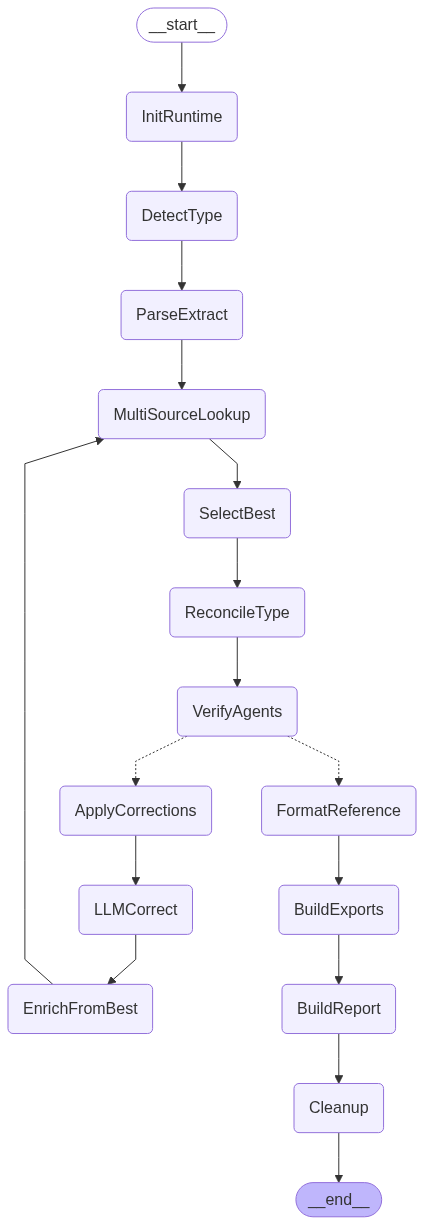

In [8]:
display(Image(compiled.get_graph().draw_mermaid_png()))